# Caffeine pharmacokinetics
Analysis of the pharmacokinetics parameters of caffeine.

**TODO**
- plot other entries: i.e., plot all results which are not part of "control, smoking & oc"
- add derived pharmacokinetic parameters (from time courses)
- add indidividual data from caffeine studies (clinical partners)
- add x-errorbars for calculated doses based on SD/SE on body weights
- calculate group data from individuals
- check Balogh1992 data set

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({
        'axes.labelsize': 'large',
        'axes.labelweight': 'bold',
        'axes.titlesize': 'medium',
        'axes.titleweight': 'bold',
        'legend.fontsize': 'small',
        'xtick.labelsize': 'large',
        'ytick.labelsize': 'large',
        'figure.facecolor': '1.00'
    })

## Load and filter pharmacokinetics data

In [2]:
# read preprocessed data 
pk_i = pd.read_csv("complete_for_individuals.tsv", sep='\t', index_col=0)
pk_g = pd.read_csv("complete_for_groups.tsv", sep='\t', index_col=0)

#path ="data.xlsx"
#pk_i = pd.read_excel(path,sheet_name="complete_for_individuals",index_col=0)
#pk_g = pd.read_excel(path,sheet_name="complete_for_groups",index_col=0)

In [3]:
# individual and group data
pk_i.columns = [eval(c) if "," in c else c for c in list(pk_i.columns) ]
pk_g.columns = [eval(c) if "," in c else c for c in list(pk_g.columns) ]

In [4]:
# ! filter Balogh1992 data 
# The measured clearances and half-lifes are not in agreement with the remaining data sets.
# TODO: Necessary to check the results based on the time course data, i.e.,
# recalculate clearances and half-lifes directly from the original data
pk_i = pk_i[(pk_i[('study', '')] != "Balogh1992")]
pk_g = pk_g[(pk_g[('study', '')] != "Balogh1992")]

In [5]:
# Filter subset of data relevant for analysis (caffeine clearance in plasma, healthy)
#& (pk_i.application == "single dose") \

idx = (pk_i.substance_name_intervention == 'caffeine') \
       & (pk_i.substance_name == 'caffeine') \
       & (pk_i[ ('healthy', 'choice')] == 'Y') \
       & (pk_i[ 'tissue'] == 'plasma') 
    
pk_i = pk_i[idx]
print("Number of measurements for individuals with selected criteria:", len(pk_i))

idx = (pk_g.substance_name_intervention == 'caffeine') \
       & (pk_g.substance_name == 'caffeine') \
       & (pk_g[ ('healthy', 'choice')] == 'Y') \
       & (pk_g[ 'tissue'] == 'plasma')
    
pk_g = pk_g[idx]
print("Number of measurements for groups with selected criteria:", len(pk_g))

Number of measurements for individuals with selected criteria: 2244
Number of measurements for groups with selected criteria: 728


In [6]:
print("Individuals")
print("unit intervention:", pk_i.unit_intervention.unique())

# absolute dose
idx_dose_abs_i = (pk_i.unit_intervention == 'mg')
# clearance per bodyweight
idx_dose_rel_i = (pk_i.unit_intervention == 'mg/kg')

Individuals
unit intervention: ['mg' 'mg/kg']


In [7]:
print("Groups")
print("unit intervetion:", pk_g.unit_intervention.unique())

# absolute dose
idx_dose_abs_g = (pk_g.unit_intervention == 'mg')
# clearance per bodyweight
idx_dose_rel_g = (pk_g.unit_intervention == 'mg/kg')

Groups
unit intervetion: ['mg/kg' 'mg']


In [8]:
#individuals_df = individuals_df[individuals_df["oral contraceptives"]["choice"]=="Y"]
#pk_i = pd.merge(pk,individuals_df.reset_index(),  how='inner', suffixes=('','subject'),left_on='individual_pk', right_on="subject_pk")
#pk_i[("oral contraceptives","choice")]

In [9]:
# Styles for plots
ccolors = {'control': 'black',
           'smoking': 'blue',
           'oc': 'green',
          }
markers = {'control': 's',
           'smoking': 'o',
           'oc': 'o',
          }

# FIXME: typo
cateogry_filter = {
    'control':{
        ('smoking', 'choice'):"N",
        ('oral contraceptives', 'choice'):'N'},
    'smoking':{
        ('smoking', 'choice'):"Y"}, 
    'oc':{
        ('oral contraceptives', 'choice'):'Y'}
}

In [10]:
#ccolors = {'men': 'black',
#           'female': 'blue',
#           
#          }
#markers = {'men': 's',
#           'female': 'o',
#          }

#cateogry_filter = {
#    'men':{
#        ('sex', 'choice'):"M"},
#    'female':{
#        ('sex', 'choice'):"F"}    
#}    


In [11]:
#ccolors = {'homo sapiens': 'black',
#           
#          }
#markers = {'homo sapiens': 's',
#          }
#
#cateogry_filter = {
#    'homo sapiens':{
#        ('species', 'choice'):"homo sapiens"}, 
#}    


In [12]:
def data_pktype(pktype, pk):
    data = pk[pk.pktype==pktype]
    print('{} ({})'.format(pktype, len(data)))
    print("units:", data.unit.unique())
    return data
    
# clearance data
print("Individuals")
cl_data_i = data_pktype('clearance', pk_i)
# absolute clearance
idx_cl_abs_i = (cl_data_i.unit == 'ml/min')
# clearance per bodyweight
idx_cl_rel_i = (cl_data_i.unit == 'ml/min/kg')

# clearance data
print("Groups")
cl_data_g = data_pktype('clearance', pk_g)
# absolute clearance
idx_cl_abs_g = (cl_data_g.unit == 'ml/min')
# clearance per bodyweight
idx_cl_rel_g = (cl_data_g.unit == 'ml/min/kg')

Individuals
clearance (804)
units: ['ml/min' 'ml/min/kg']
Groups
clearance (182)
units: ['ml/min' 'ml/min/kg' 'ml/min/1.73m^2']


In [13]:
cl_data_i.groupby("unit")["value"].count()

unit
ml/min       385
ml/min/kg    416
Name: value, dtype: int64

In [14]:
cl_data_g.groupby("unit")["mean"].count()

unit
ml/min            78
ml/min/1.73m^2     4
ml/min/kg         96
Name: mean, dtype: int64

In [15]:
def filter_df(filter_dict, df):
    for filter_key, filter_value in filter_dict.items():
        df = df[df[filter_key]==filter_value]
    return df

In [16]:
for category in ccolors:
        cf_filter = cateogry_filter[category]
        df_category = filter_df(cf_filter,cl_data_i)
        print(category, len(df_category))

control 325
smoking 300
oc 141


## Caffeine clearance (individuals)

/home/mkoenig/envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


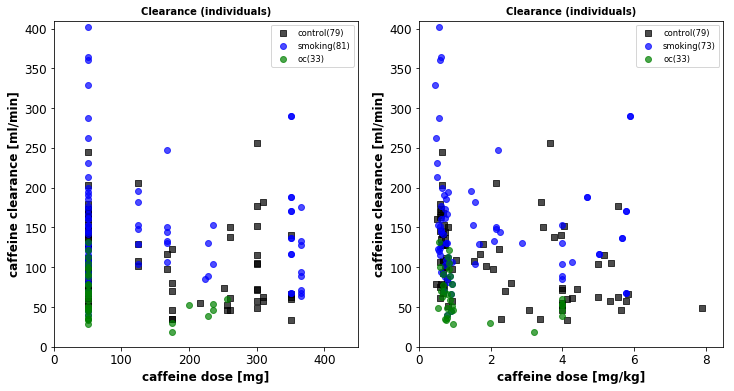

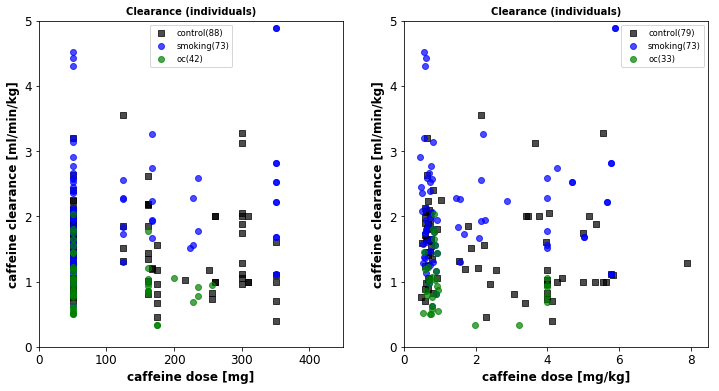

In [33]:
# caffeine clearance
data = cl_data_i
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig2, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

dinds = [idx_dose_abs_i & idx_cl_abs_i,
         idx_dose_rel_i & idx_cl_abs_i,
         idx_dose_abs_i & idx_cl_rel_i,
         idx_dose_rel_i & idx_cl_rel_i]
for ax, inds in zip((ax1, ax2, ax3, ax4), dinds):
    df = data[inds]
    
    for category in ccolors:
        cf_filter = cateogry_filter[category]
        df_category = filter_df(cf_filter,df)
        x = df_category["value_intervention"]
        #x = df_category[("age","value")]

        y = df_category.value
        ax.scatter(x, y,color=ccolors[category], marker=markers[category], label=f"{category}({len(x)})", alpha=0.7)
        #sns.distplot( y,ax =ax,color=ccolors[category],  label=f"{category}({len(x)})",kde_kws={'clip': (0.0,100000 )})

        #for i, txt in enumerate(df_category[('study', '')]):
        #    ax.annotate(txt, (x.iloc[[i]],
        #                      y.iloc[[i]]), alpha=0.7)
    
for ax in (ax1, ax2, ax3, ax4):
    ax.set_title('Clearance (individuals)')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.legend()

for ax in (ax1, ax2):
    ax.set_ylabel('caffeine clearance [ml/min]')
    ax.set_ylim(0, 410)
    
for ax in (ax3, ax4):
    ax.set_ylabel('caffeine clearance [ml/min/kg]')
    ax.set_ylim(0, 5)

for ax in (ax1, ax3):
    ax.set_xlabel('caffeine dose [mg]')
    ax.set_xlim(0, 450)

for ax in (ax2, ax4):
    ax.set_xlabel('caffeine dose [mg/kg]')
    ax.set_xlim(0, 8.5)

fig1.savefig("figures/caf_cl_individuals.png", bbox_inches="tight")
fig2.savefig("figures/caf_clbw_individuals.png", bbox_inches="tight")

## Caffeine AUC (individuals)

/home/mkoenig/envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


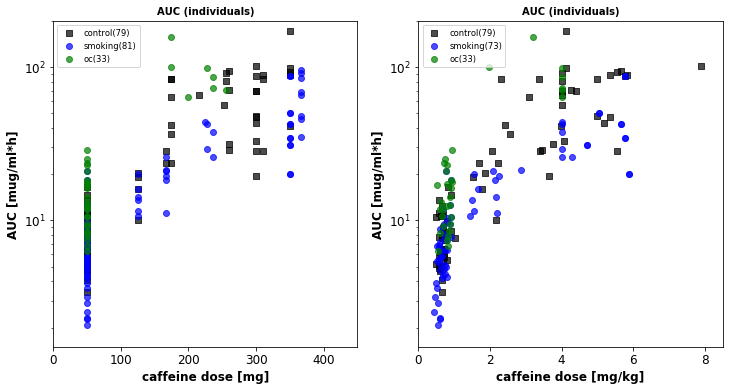

In [48]:
# caffeine auc
data = cl_data_i
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

dinds = [idx_dose_abs_i & idx_cl_abs_i,
         idx_dose_rel_i & idx_cl_rel_i]
for ax, inds in zip((ax1, ax2), dinds):
    df = data[inds]
    
    for category in ccolors:
        cf_filter = cateogry_filter[category]
        df_category = filter_df(cf_filter,df)
        x = df_category["value_intervention"]
        #x = df_category[("age","value")]

        y =(df_category["value_intervention"] / df_category.value)*1000 /60        
        ax.scatter(x, y,color=ccolors[category], marker=markers[category], label=f"{category}({len(x)})", alpha=0.7)
        #sns.distplot( y,ax =ax,color=ccolors[category],  label=f"{category}({len(x)})",kde_kws={'clip': (0.0,100000 )})

        #for i, txt in enumerate(df_category[('study', '')]):
        #    ax.annotate(txt, (x.iloc[[i]],
        #                      y.iloc[[i]]), alpha=0.7)
    
for ax in (ax1, ax2):
    ax.set_title("AUC (individuals)")
    ax.set_ylabel('AUC [mug/ml*h]')
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    # ax.set_ylim(0, 175)
    ax.set_ylim(1.5, 200)
    ax.set_yscale("log")
    ax.legend()
    
for ax in (ax1, ):
    ax.set_xlabel('caffeine dose [mg]')
    ax.set_xlim(0, 450)
for ax in (ax2, ):
    ax.set_xlabel('caffeine dose [mg/kg]')
    ax.set_xlim(0, 8.5)

fig.savefig("figures/caf_auc_individuals.png", bbox_inches="tight")

## Caffeine clearance (groups)

In [19]:
for category in ccolors:
        cf_filter = cateogry_filter[category]
        df_category = filter_df(cf_filter,cl_data_g)
        print(category, len(df_category))

control 58
smoking 32
oc 12


In [20]:
#cl_data_g.groupby([('oral contraceptives', 'choice'),('smoking', 'choice')])["mean"].count()
#len(cl_data_g)
#cl_data_g.groupby(('smoking', 'choice'))
#cl_data_g[[('smoking', "count"),('oral contraceptives', "count")]]

/home/mkoenig/envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


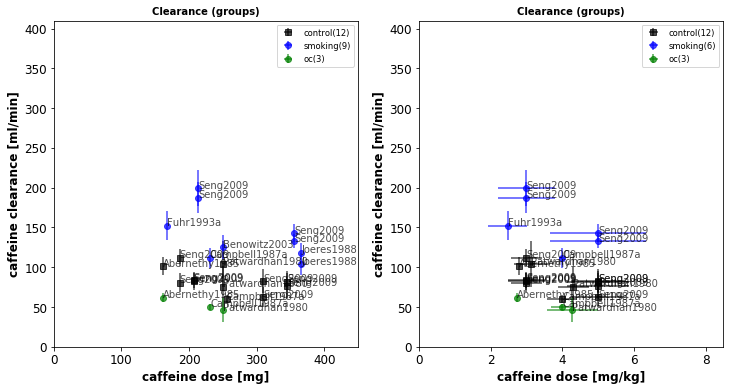

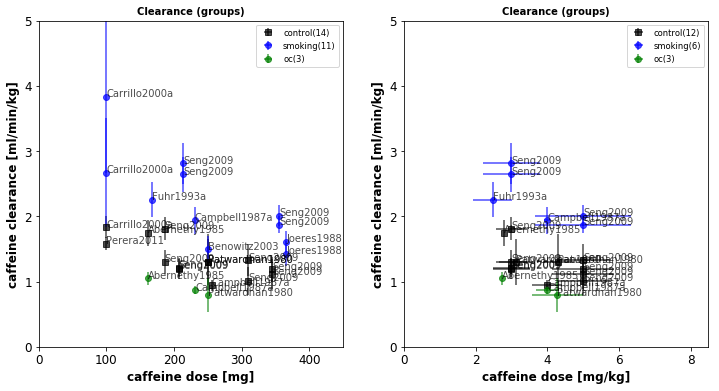

In [35]:
# caffeine clearance
data = cl_data_g[cl_data_g["mean"].notnull()]
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig2, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

dinds = [idx_dose_abs_g & idx_cl_abs_g,
         idx_dose_rel_g & idx_cl_abs_g,
         idx_dose_abs_g & idx_cl_rel_g,
         idx_dose_rel_g & idx_cl_rel_g]
for ax, inds in zip((ax1, ax2, ax3, ax4), dinds):
    df = data[inds]
    
    for category in ccolors:
        cf_filter = cateogry_filter[category]
        df_category = filter_df(cf_filter,df)
        x = df_category["value_intervention"]
        y = df_category["mean"]
        if ax in (ax2, ax4):
            xerr = (df_category[("weight","sd")]/df_category[("weight","mean")])*x
        else:
            xerr = 0
        yerr = df_category["se"]
        #sns.distplot( y,ax =ax,color=ccolors[category],  label=f"{category}({len(x)})",kde_kws={'clip': (0.0,100000 )})

        ax.errorbar(x, y,yerr=yerr,xerr=xerr,color=ccolors[category], fmt=markers[category],  label=f"{category}({len(x)})", alpha=0.7)
        for i, txt in enumerate(df_category[('study', '')]):
            ax.annotate(txt, (x.iloc[[i]],
                              y.iloc[[i]]), alpha=0.7)
    
for ax in (ax1, ax2, ax3, ax4):
    ax.set_title('Clearance (groups)')
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    ax.legend()

for ax in (ax1, ax2):
    ax.set_ylabel('caffeine clearance [ml/min]')
    ax.set_ylim(0, 410)

for ax in (ax3, ax4):
    ax.set_ylabel('caffeine clearance [ml/min/kg]')
    ax.set_ylim(0, 5)

for ax in (ax1, ax3):
    ax.set_xlabel('caffeine dose [mg]')
    ax.set_xlim(0, 450)

for ax in (ax2, ax4):
    ax.set_xlabel('caffeine dose [mg/kg]')
    ax.set_xlim(0, 8.5)

fig1.savefig("figures/caf_cl_groups.png", bbox_inches="tight")
fig2.savefig("figures/caf_clbw_groups.png", bbox_inches="tight")

## Caffeine AUC (groups)

/home/mkoenig/envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


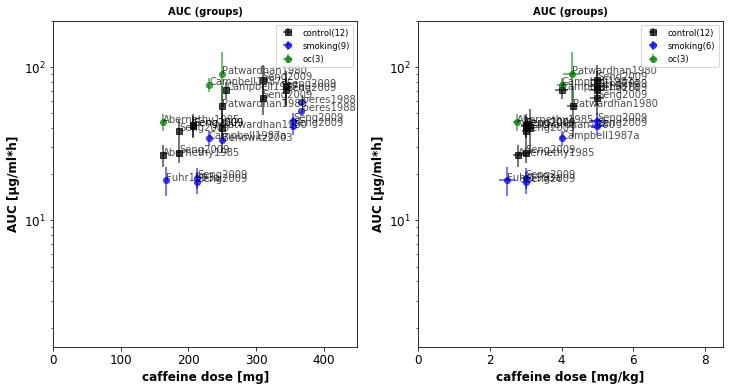

In [49]:
# caffeine auc
data = cl_data_g[cl_data_g["mean"].notnull()]
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

dinds = [idx_dose_abs_g & idx_cl_abs_g,
         idx_dose_rel_g & idx_cl_rel_g]
for ax, inds in zip((ax1, ax2), dinds):
    df = data[inds]
    
    for category in ccolors:
        cf_filter = cateogry_filter[category]
        df_category = filter_df(cf_filter,df)
        x = df_category["value_intervention"]
        #x = df_category[("age","value")]

        y =(df_category["value_intervention"] / df_category["mean"])*1000 /60
        
    
        if ax in (ax2, ax4):
            xerr = (df_category[("weight","se")]/df_category[("weight","mean")])*x
        else:
            xerr = 0
        yerr = ((df_category["se"]/df_category["mean"])+(df_category[("weight","se")]/df_category[("weight","mean")]))*y
        #sns.distplot( y,ax =ax,color=ccolors[category],  label=f"{category}({len(x)})",kde_kws={'clip': (0.0,100000 )})

        ax.errorbar(x, y,yerr=yerr,xerr=xerr,color=ccolors[category], fmt=markers[category],  label=f"{category}({len(x)})", alpha=0.7)
        for i, txt in enumerate(df_category[('study', '')]):
            ax.annotate(txt, (x.iloc[[i]],
                              y.iloc[[i]]), alpha=0.7)
    
for ax in (ax1, ax2):
    ax.set_title("AUC (groups)")
    ax.set_ylabel('AUC [µg/ml*h]')
    ax.set_xlim(left=0)
    # ax.set_ylim(bottom=0)
    ax.set_ylim(1.5, 200)
    ax.set_yscale("log")
    ax.legend()
    
for ax in (ax1, ):
    ax.set_xlabel('caffeine dose [mg]')
    ax.set_xlim(0, 450)
    
for ax in (ax2, ):
    ax.set_xlabel('caffeine dose [mg/kg]')
    ax.set_xlim(0, 8.5)

fig.savefig("figures/caf_auc_groups.png", bbox_inches="tight")

## Caffeine half-life (individuals)

thalf (380)
units: ['h']


/home/mkoenig/envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


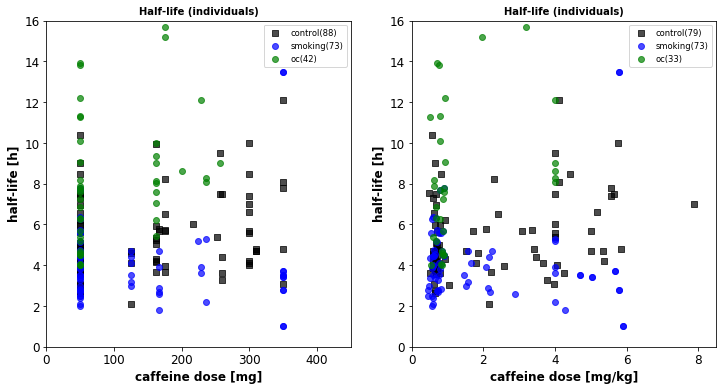

In [37]:
# plot apparent volume of distribution
data = data_pktype('thalf',pk_i)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

dinds = [idx_dose_abs_i,
         idx_dose_rel_i]
for ax, inds in zip((ax1, ax2), dinds):
    df = data[inds]
    for category in ccolors:
        cf_filter = cateogry_filter[category]
        df_category = filter_df(cf_filter,df)
        x = df_category["value_intervention"]
        #x = df_category[("age","value")]

        y = df_category.value
        ax.scatter(x, y,color=ccolors[category], marker=markers[category], label=f"{category}({len(x)})", alpha=0.7)
for ax in (ax1, ax2):
    ax.set_title("Half-life (individuals)")
    ax.set_ylabel('half-life [h]')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.set_ylim(0, 16)
    ax.legend()
    
for ax in (ax1, ):
    ax.set_xlabel('caffeine dose [mg]')
    ax.set_xlim(0, 450)
for ax in (ax2, ):
    ax.set_xlabel('caffeine dose [mg/kg]')
    ax.set_xlim(0, 8.5)
    
fig.savefig("figures/caf_halflife_individuals.png", bbox_inches="tight")

## Caffeine half-life (groups)

thalf (84)
units: ['h']


/home/mkoenig/envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


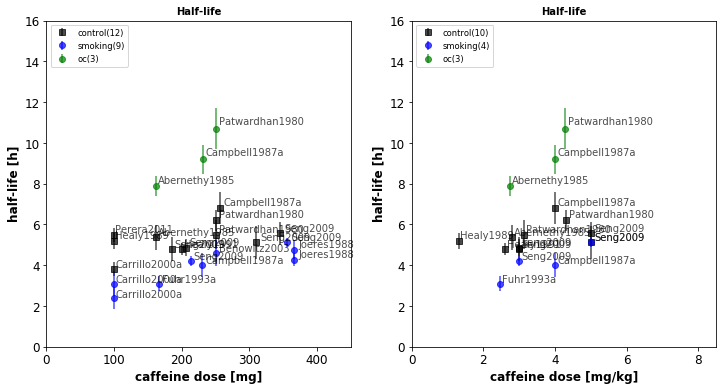

In [40]:
# half-life
data = data_pktype('thalf',pk_g)
data = data[data["mean"].notnull()]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

dinds = [idx_dose_abs_g,
         idx_dose_rel_g]
for ax, inds in zip((ax1, ax2), dinds):
    df = data[inds]
    for category in ccolors:
        cf_filter = cateogry_filter[category]
        df_category = filter_df(cf_filter,df)
        x = df_category["value_intervention"]
        #x = df_category[("age","value")]

        y = df_category["mean"]
        yerr = df_category["se"]
        #sns.distplot( y,ax =ax,color=ccolors[category],  label=f"{category}({len(x)})",kde_kws={'clip': (0.0,100000 )})

        ax.errorbar(x, y,yerr=yerr,color=ccolors[category], fmt=markers[category],  label=f"{category}({len(x)})", alpha=0.7)
        for i, txt in enumerate(df_category[('study', '')]):
            ax.annotate(txt, (x.iloc[[i]]+0.02*x.iloc[[i]].mean(),
                              y.iloc[[i]]+0.02*y.iloc[[i]].mean()), alpha=0.7)
    
for ax in (ax1, ax2):
    ax.set_title("Half-life")
    ax.set_ylabel('half-life [h]')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.set_ylim(0, 16)
    ax.legend(loc="upper left")
    
for ax in (ax1, ):
    ax.set_xlabel('caffeine dose [mg]')
    ax.set_xlim(0, 450)
    
for ax in (ax2, ):
    ax.set_xlabel('caffeine dose [mg/kg]')
    ax.set_xlim(0, 8.5)

fig.savefig("figures/caf_halflife_groups.png", bbox_inches="tight")

## cmax(peak concentration)

### Individuals

cmax (40)
units: ['µg/ml']


/home/mkoenig/envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


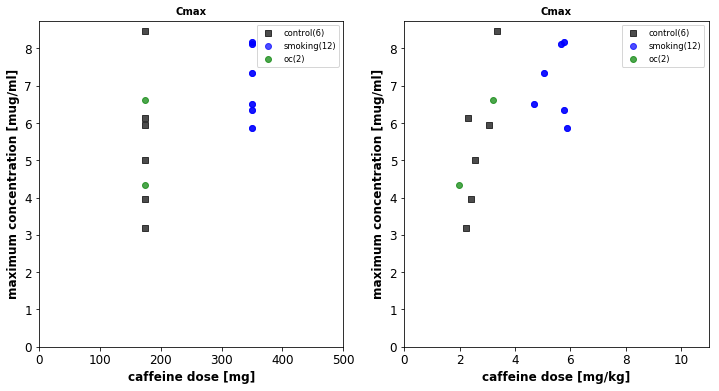

In [25]:
# plot apparent volume of distribution
data = data_pktype('cmax',pk_i)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

dinds = [idx_dose_abs_i,
         idx_dose_rel_i]
for ax, inds in zip((ax1, ax2), dinds):
    df = data[inds]
    for category in ccolors:
        cf_filter = cateogry_filter[category]
        df_category = filter_df(cf_filter,df)
        x = df_category["value_intervention"]
        #x = df_category[("age","value")]

        y = df_category.value
        ax.scatter(x, y,color=ccolors[category], marker=markers[category], label=f"{category}({len(x)})", alpha=0.7)
for ax in (ax1, ax2):
    ax.set_title("Cmax")
    ax.set_ylabel('maximum concentration [mug/ml]')
    ax.set_ylim(bottom=0)
    ax.legend()
    
    
for ax in (ax1, ):
    ax.set_xlim(0, 500)
    ax.set_xlabel('caffeine dose [mg]')
for ax in (ax2, ):
    ax.set_xlim(0, 11)
    # ax.set_ylim(0, 10)
    ax.set_xlabel('caffeine dose [mg/kg]')



### Groups

cmax (44)
units: ['µg/ml' 'µmol/l']


/home/mkoenig/envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


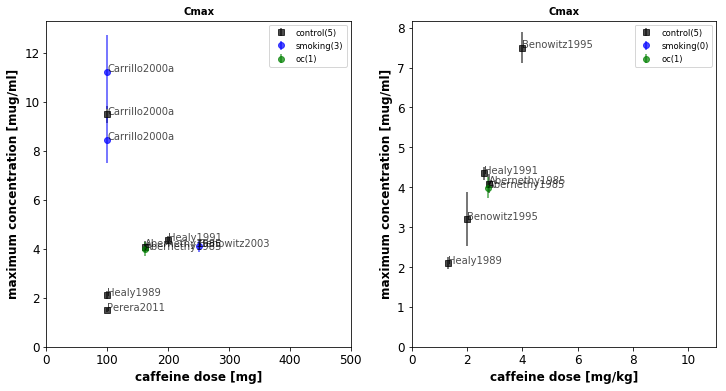

In [26]:
# plot apparent volume of distribution
data = data_pktype('cmax',pk_g)
data = data[data["mean"].notnull()]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

dinds = [idx_dose_abs_g,
         idx_dose_rel_g]
for ax, inds in zip((ax1, ax2), dinds):
    df = data[inds]
    for category in ccolors:
        cf_filter = cateogry_filter[category]
        df_category = filter_df(cf_filter,df)
        x = df_category["value_intervention"]
        #x = df_category[("age","value")]

        y = df_category["mean"]
        yerr = df_category["se"]
        #sns.distplot( y,ax =ax,color=ccolors[category],  label=f"{category}({len(x)})",kde_kws={'clip': (0.0,100000 )})

        ax.errorbar(x, y,yerr=yerr,color=ccolors[category], fmt=markers[category],  label=f"{category}({len(x)})", alpha=0.7)
        for i, txt in enumerate(df_category[('study', '')]):
            ax.annotate(txt, (x.iloc[[i]],
                              y.iloc[[i]]), alpha=0.7)
    
for ax in (ax1, ax2):
    ax.set_title("Cmax")
    ax.set_ylabel('maximum concentration [mug/ml]')
    ax.set_ylim(bottom=0)
    ax.legend()
    
    
for ax in (ax1, ):
    ax.set_xlim(0, 500)
    ax.set_xlabel('caffeine dose [mg]')
for ax in (ax2, ):
    ax.set_xlim(0, 11)
    # ax.set_ylim(0, 10)
    ax.set_xlabel('caffeine dose [mg/kg]')



## AUC

### Individuals

/home/mkoenig/envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


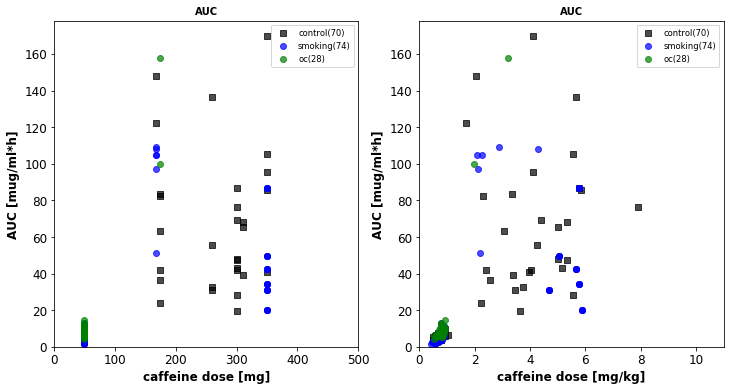

In [27]:
# plot apparent volume of distribution
#data = data_pktype('auc_inf',pk_i)
data = pk_i[pk_i.apply(lambda pk: (pk.pktype in ['auc_inf','auc_end']) , axis=1)]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

dinds = [idx_dose_abs_i,
         idx_dose_rel_i]
for ax, inds in zip((ax1, ax2), dinds):
    df = data[inds]
    for category in ccolors:
        cf_filter = cateogry_filter[category]
        df_category = filter_df(cf_filter,df)
        x = df_category["value_intervention"]
        #x = df_category[("age","value")]

        y = df_category.value
        ax.scatter(x, y,color=ccolors[category], marker=markers[category], label=f"{category}({len(x)})", alpha=0.7)

for ax in (ax1, ax2):
    ax.set_title("AUC")
    ax.set_ylabel('AUC [mug/ml*h]')
    ax.set_ylim(bottom=0)
    ax.legend()
    
    
for ax in (ax1, ):
    ax.set_xlim(0, 500)
    ax.set_xlabel('caffeine dose [mg]')
for ax in (ax2, ):
    ax.set_xlim(0, 11)
    ax.set_xlabel('caffeine dose [mg/kg]')



### Groups

In [28]:
 pk_g[pk_g.apply(lambda pk: (pk.pktype in ['auc_inf','auc_end']), axis=1)].groupby("unit").count()

,pktype,tissue,interventions,substance_name,individual_pk,value,group_pk,mean,se,time,...,"(metabolic ratio, min)","(metabolic ratio, unit)","(medication type, choice)","(medication type, count)","(smoking amount (packyears), count)","(smoking amount (packyears), min)","(smoking amount (packyears), unit)","(caffeine amount (beverages), count)","(caffeine amount (beverages), max)","(caffeine amount (beverages), unit)"
unit,,,,,,,,,,,,,,,,,,,,,
mg*h/l,39,39,39,39,0,0,39,39,37,28,...,0,0,0,0,0,0,0,2,2,2
µg*h/ml,6,6,6,6,0,0,6,6,2,0,...,0,0,0,0,0,0,0,0,0,0
µg*min/ml,58,58,58,58,0,0,58,58,58,0,...,0,0,0,0,0,0,0,0,0,0
µmol*h/l,6,6,6,6,0,0,6,4,4,0,...,0,0,0,0,0,0,0,0,0,0
µmol/l*h,4,4,4,4,0,0,4,4,4,0,...,0,0,0,0,0,0,0,0,0,0


/home/mkoenig/envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


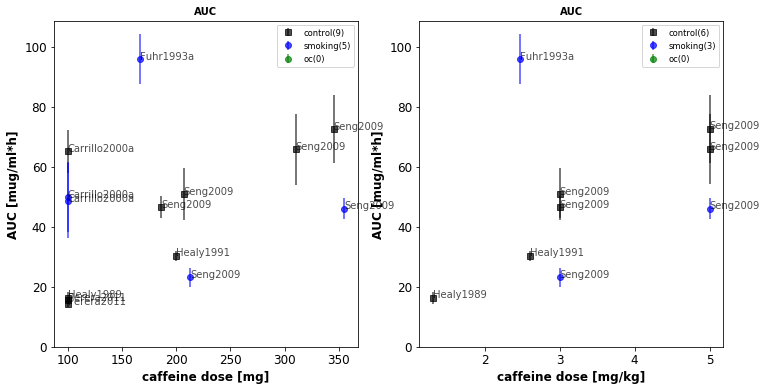

In [29]:
# plot apparent volume of distribution
data = pk_g[pk_g.apply(lambda pk: (pk.pktype in ['auc_inf','auc_end']) , axis=1)]


data = data[data["mean"].notnull()]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

dinds = [idx_dose_abs_g,
         idx_dose_rel_g]
for ax, inds in zip((ax1, ax2), dinds):
    df = data[inds]
    for category in ccolors:
        cf_filter = cateogry_filter[category]
        df_category = filter_df(cf_filter,df)
        x = df_category["value_intervention"]
        #x = df_category[("age","value")]

        y = df_category["mean"]
        yerr = df_category["se"]
        #sns.distplot( y,ax =ax,color=ccolors[category],  label=f"{category}({len(x)})",kde_kws={'clip': (0.0,100000 )})

        ax.errorbar(x, y,yerr=yerr,color=ccolors[category], fmt=markers[category],  label=f"{category}({len(x)})", alpha=0.7)
        for i, txt in enumerate(df_category[('study', '')]):
            ax.annotate(txt, (x.iloc[[i]],
                              y.iloc[[i]]), alpha=0.7)
    
for ax in (ax1, ax2):
    ax.set_title("AUC")
    ax.set_ylabel('AUC [mug/ml*h]')
    ax.set_ylim(bottom=0)
    ax.legend()
    
    
for ax in (ax1, ):
    #ax.set_xlim(0, 500)
    ax.set_xlabel('caffeine dose [mg]')
for ax in (ax2, ):
    #ax.set_xlim(0, 11)
    ax.set_xlabel('caffeine dose [mg/kg]')

